### Swisscom assignment

**Dataset:** Heart Attack Possibility (https://www.kaggle.com/nareshbhat/health-care-data-set-on-heart-attack-possibility )   

**Task:** Predict the risk of heart attack 

**Challenge:** Assess the impact of the age and gender

### Notebook organisation:
1. Data loading and preparation
2. Traning classification models
3. Evaluate models
4. Task: Predict risk of heart attack
5. Challenge: assess feature importance

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

## 1. Data loading and preparation

In [2]:
df = pd.read_csv("data/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
pd.set_option('float_format', '{:.2f}'.format) # too have only two floating point numbers
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,54.37,0.68,0.97,131.62,246.26,0.15,0.53,149.65,0.33,1.04,1.40,0.73,2.31,0.54
std,9.08,0.47,1.03,17.54,51.83,0.36,0.53,22.91,0.47,1.16,0.62,1.02,0.61,0.50
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,47.50,0.00,0.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00,2.00,0.00
50%,55.00,1.00,1.00,130.00,240.00,0.00,1.00,153.00,0.00,0.80,1.00,0.00,2.00,1.00
75%,61.00,1.00,2.00,140.00,274.50,0.00,1.00,166.00,1.00,1.60,2.00,1.00,3.00,1.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,2.00,4.00,3.00,1.00


#### Data separation

Since the dataset is small (303 datapoints), I choose to use cross-validation with a 80/20 train/test split, so 5-fold. That way, I don't "waste" any datapoint for testing.

In [4]:
def build_k_fold_indices(y, k, seed):
    """ Fuction that builds k train/test pairs of list of indices for k-fold cross-validation."""
    num_row = y.shape[0]
    interval = int(num_row / k)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    
    k_indices = []
    for i in range(k):
        test_idx = indices[i * interval: (i + 1) * interval]
        train_idx = np.setdiff1d(np.array(y.index), test_idx)
        k_indices.append([train_idx, test_idx])
    
    return k_indices

def check_repartition(y, y_train, y_test):
    ''' Fuction that prints the repartition of labels in training/testing sets.'''
    print('Ratio of ones:')
    print('Whole dataset: {:.2f}%'.format(y.values.sum()/len(y)*100))
    print('Train set: {:.2f}%'.format(y_train.values.sum()/len(y_train)*100))
    print('Test set: {:.2f}%\n'.format(y_test.values.sum()/len(y_test)*100))

In [5]:
X = df.drop('target', axis=1)
y = df['target']

# Performing k-fold separation
k_fold_indices = build_k_fold_indices(y, k=5, seed=42)

# Checking if repartition of acceptable
for idx in k_fold_indices:
    y_train, y_test = y.iloc[idx[0]], y.iloc[idx[1]]
    check_repartition(y, y_train, y_test)

Ratio of ones:
Whole dataset: 54.46%
Train set: 54.73%
Test set: 53.33%

Ratio of ones:
Whole dataset: 54.46%
Train set: 52.26%
Test set: 63.33%

Ratio of ones:
Whole dataset: 54.46%
Train set: 55.97%
Test set: 48.33%

Ratio of ones:
Whole dataset: 54.46%
Train set: 54.73%
Test set: 53.33%

Ratio of ones:
Whole dataset: 54.46%
Train set: 54.73%
Test set: 53.33%



## 2. Traning classification models


We train several classifiers to see which performs best:
- Naive Bayes
- Logistic Regression
- Decision tree & Random Forest
- Support Vector Machine
- K Nearest Neighbours

In [6]:
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(solver='newton-cg'), 
    'Decision Tree': tree.DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=20, random_state=42, max_depth=5),
    'SVM': SVC(probability=True),
    'kNN': KNeighborsClassifier(n_neighbors=20)
}

In [7]:
# Training the models

accuracy = []
recall = []
cm = []
for i, m in enumerate(models.values()):
    accuracy_temp = []
    recall_temp = []
    cm_temp = []
    for idx in k_fold_indices: # idx = [train_idx, test_idx]
        x_train, y_train = X.iloc[idx[0]], y.iloc[idx[0]]  
        x_test, y_test = X.iloc[idx[1]], y.iloc[idx[1]]
        m.fit(x_train, y_train)
        
        y_pred = m.predict(x_test)
        accuracy_temp.append(accuracy_score(y_test, y_pred))
        recall_temp.append(recall_score(y_test, y_pred))
        cm_temp.append(confusion_matrix(y_test, y_pred))
        
    accuracy.append(np.mean(accuracy_temp)*100)
    recall.append(np.mean(recall_temp)*100)
    cm.append(np.mean(cm_temp, axis=0))

## 3. Evaluate models

In [8]:
acc = pd.DataFrame({'Model': models.keys(), 'Accuracy': accuracy, 'Recall': recall})
acc.set_index('Model', inplace=True)
acc

,Accuracy,Recall
Model,,
Naive Bayes,80.67,83.98
Logistic Regression,82.33,89.58
Decision Tree,77.67,79.81
Random Forest,81.00,86.71
SVM,66.33,82.97
kNN,66.00,70.11


Best performing models: **Naive Bayes**, **Logistic Regression** and **Random Forest**.

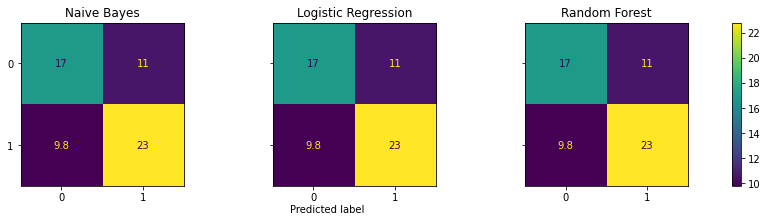

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 3), sharey='row')

for plot_idx, model_name in enumerate(['Naive Bayes', 'Logistic Regression', 'Random Forest']):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=axes[plot_idx])
    disp.ax_.set_title(model_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0: 
        disp.ax_.set_ylabel('')

fig.text(0.4, 0.0, 'Predicted label', ha='left')
fig.colorbar(disp.im_, ax=axes)
plt.show()

#### ––> Logistic Regression if the best fit

We can see that it performs better in has the best performances in both accuracy and recall. Recall is an important evaluation method in that case, because we want to avoid as much as possible to not detect a case of heart attack.

In [10]:
model = models['Logistic Regression']

## 4. Task: Predict risk of heart attack

Now, to predict the risk and not the label, we can use the ```.predict_proba``` function of our trained logistic regression model.

In [11]:
sample_point = np.array(x_test.iloc[1])
proba = model.predict_proba(sample_point.reshape(1, -1))
print('Risk of heart attack for the sample point: {:.2f}'.format(proba[0][1] * 100))

Risk of heart attack for the sample point: 90.01


Bad news :(

## 5. Challenge: assess feature importance

In [12]:
# With logistic regression, the coefficient represent the importance of the features

feature_importance = pd.DataFrame({
    'features': x_train.columns,
    'importances': abs(model.coef_[0]),
})
feature_importance

,features,importances
0,age,0.02
1,sex,1.59
2,cp,0.73
3,trestbps,0.01
4,chol,0.00
5,fbs,0.01
6,restecg,0.43
7,thalach,0.02
8,exang,0.83
9,oldpeak,0.60


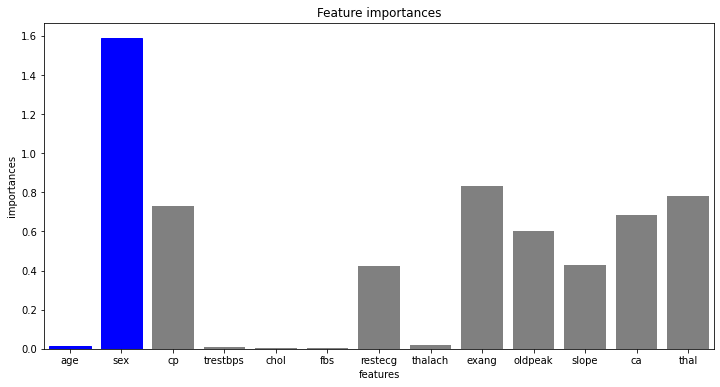

In [13]:
# let's plot that 
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(x='features', y='importances', data=feature_importance, color='grey')
ax.set_title("Feature importances")

# change color for features 'sex' and 'age'
indexes = feature_importance[(feature_importance['features'] == 'sex') | (feature_importance['features'] == 'age')].index
for i in indexes:
    ax.get_children()[i].set_color('b')

plt.show()

We can see that age seems not important at all, while the gender is an importance feature – quite the opposite from what we would expect. Let's try to understand why.

In [14]:
df[['age', 'sex']].describe()

,age,sex
count,303.00,303.00
mean,54.37,0.68
std,9.08,0.47
min,29.00,0.00
25%,47.50,0.00
50%,55.00,1.00
75%,61.00,1.00
max,77.00,1.00


#### Analysis feature 1: Age

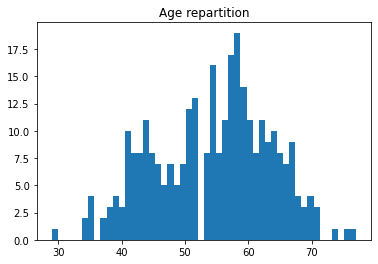

In [15]:
plt.hist(df['age'], bins=50)
plt.title('Age repartition')
plt.show()

This low importance can be explained by the face that the sample is biaised: there is not a lot of small-aged subject in the dataset. Indeed the mean is 54 years old, and the younger datapoint in 29 years old. This is why this feature does not influence a lot our model. We can expect that if we had some datapoints of young age, which more likely did not have a heart attack, this feature would gain a lot more importance.

#### Analysis feature 2: Gender

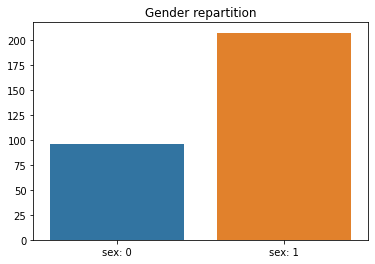

In [16]:
ones = df['sex'].sum()
sns.barplot(x=['sex: 0', 'sex: 1'], y=[len(df)-ones, ones])
plt.title('Gender repartition')
plt.show()

Gender repartition per label:


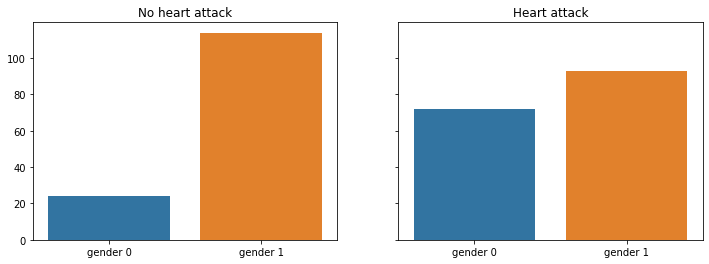

In [17]:
print('Gender repartition per label:')

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey='row')

sex0_target0 = len(df[(df['sex'] == 0) & (df['target'] == 0)])
sex1_target0 = len(df[(df['sex'] == 1) & (df['target'] == 0)])
sex0_target1 = len(df[(df['sex'] == 0) & (df['target'] == 1)])
sex1_target1 = len(df[(df['sex'] == 1) & (df['target'] == 1)])

sns.barplot(x=['gender 0', 'gender 1'], y=[sex0_target0, sex1_target0], ax=axes[0])
axes[0].set_title('No heart attack')
sns.barplot(x=['gender 0', 'gender 1'], y=[sex0_target1, sex1_target1], ax=axes[1])
axes[1].set_title('Heart attack')

plt.show()

The unexpected high importance of the sex feature is explained by this repartition.
- Indeed, first of all there is a big imbalance in the ratio of the two gender (96 and 207)
- And within this imbalance, for the category 0 a very few didn't get a heart attack.